In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from keras.layers import GRU
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
import plotly.graph_objs as go
import plotly.offline as offline
import tensorflow as tf
from IPython.display import Image
from tensorflow.keras.optimizers.schedules import ExponentialDecay

**2015-2021 yılları arasında Aselsan şirketinin değerlerini Borsa İstanbul BIST 30 veri setinden inceledim. Proje boyunca, şirketin kapanış değerleri üzerinden işlemler gerçekleştirdim. Projenin sonlarına doğru, ayrıca açılış, en yüksek ve kapanış değerleri üzerine bir çalışma yaptım. Modeller olarak, RNN with Adam, RNN with RMSprop, LSTM ve GRU kullanmayı tercih ettim. Her bir modelde aktivasyon fonksiyonları, optimizasyon fonksiyonları ve katman sayılarıyla oynayarak istediğim performansı elde etmeye çalıştım. İlk iki modele ek olarak, Learning Rate Scheduler ekledim. Proje sonlarına doğru, sonuçların doğruluğunu göstermeye ve modelimin Aselsan hisselerinden farklı olan BIOEN şirketinin hisse değerleri ile nasıl çalıştığını göstermeye çalıştım.**

1.) Hisse senedi fiyatının zaman içinde değişimi ne oldu?

2.) Hisse senedinin günlük getirisi ortalama ne kadardı?

3.) Çeşitli hisse senetlerinin hareketli ortalaması neydi?

4.) Farklı hisse senetleri arasındaki korelasyon neydi?

5.) Belirli bir hisse senedine yatırım yaparak ne kadar değeri riske atıyoruz?

6.) Gelecekteki hisse senedi davranışını nasıl tahmin etmeye çalışabiliriz? (APPLE Inc.'in kapanış fiyatı hisse senedi fiyatının LSTM kullanılarak tahmin edilmesi)

In [2]:
df = pd.read_csv("C:/Users/Serkan POLAT/Desktop/Borsa Istanbul Turkish Stock Exchange Dataset/Finansal Zaman Serisi Tahmin Projesi/stocks/ASELS.csv")

In [3]:
df

,TRADE DATE,INSTRUMENT SERIES CODE,INSTRUMENT NAME,MARKET SEGMENT,MARKET,INSTRUMENT TYPE,INSTRUMENT CLASS,MARKET MAKER,BIST 100 INDEX,BIST 30 INDEX,...,SHORT SALE VWAP,TRADED VALUE OF SHORT SALE TRADES,TRADED VOLUME OF SHORT SALE TRADES,NUMBER OF CONTRACTS OF SHORT SALE TRADES,LOWEST TRADE REPORT PRICE,HIGHEST TRADE REPORT PRICE,TRADE REPORT VWAP,TRADE REPORT TRADED VALUE,TRADE REPORT TRADED VOLUME,NUMBER OF TRADE REPORTS
0,2015-11-30,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,0,...,16.541,1123013.36,67893,198,0.0,0.0,0.0,0.0,0,0
1,2015-12-01,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,0,...,16.825,887236.89,52734,82,0.0,0.0,0.0,0.0,0,0
2,2015-12-02,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,0,...,16.905,252597.73,14942,75,0.0,0.0,0.0,0.0,0,0
3,2015-12-03,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,0,...,16.620,1183598.07,71216,178,0.0,0.0,0.0,0.0,0,0
4,2015-12-04,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,0,...,16.239,872771.40,53747,206,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,2021-12-27,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,1,...,22.150,66058617.12,2982265,2771,0.0,0.0,0.0,0.0,0,0
1527,2021-12-28,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,1,...,21.420,31302245.84,1461326,1290,0.0,0.0,0.0,0.0,0,0
1528,2021-12-29,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,1,...,21.276,15303091.90,719261,1188,0.0,0.0,0.0,0.0,0,0
1529,2021-12-30,ASELS,ASELSAN,Z,MSPOT,MSPOTEQT,MSPOTEQTASELS,0,1,1,...,21.514,20101419.46,934330,899,0.0,0.0,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 47 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   TRADE DATE                                      1531 non-null   object 
 1   INSTRUMENT SERIES CODE                          1531 non-null   object 
 2   INSTRUMENT NAME                                 1531 non-null   object 
 3   MARKET SEGMENT                                  1531 non-null   object 
 4   MARKET                                          1531 non-null   object 
 5   INSTRUMENT TYPE                                 1531 non-null   object 
 6   INSTRUMENT CLASS                                1531 non-null   object 
 7   MARKET MAKER                                    1531 non-null   int64  
 8   BIST 100 INDEX                                  1531 non-null   int64  
 9   BIST 30 INDEX                            

In [5]:
df.shape

(1531, 47)

In [6]:
df = df[['TRADE DATE','INSTRUMENT NAME','OPENING PRICE','LOWEST PRICE','HIGHEST PRICE','CLOSING SESSION PRICE','TOTAL TRADED VOLUME']]
df2 = df[['OPENING PRICE','HIGHEST PRICE','CLOSING SESSION PRICE']]

In [7]:
df.head()

,TRADE DATE,INSTRUMENT NAME,OPENING PRICE,LOWEST PRICE,HIGHEST PRICE,CLOSING SESSION PRICE,TOTAL TRADED VOLUME
0,2015-11-30,ASELSAN,16.10,16.06,17.02,16.61,2034094.0
1,2015-12-01,ASELSAN,16.66,16.63,16.98,16.79,1011765.0
2,2015-12-02,ASELSAN,16.85,16.60,17.14,16.60,934411.0
3,2015-12-03,ASELSAN,16.65,16.16,16.90,16.20,640974.0
4,2015-12-04,ASELSAN,16.30,16.01,16.38,16.34,414105.0


In [8]:
trace_high = go.Scatter(x=df['TRADE DATE'],
                        y=df['HIGHEST PRICE'],
                        
                        name = "ASELSAN Yükseliş",
                        
                        line = dict(color = '#6699FF')
                       )
trace_low = go.Scatter( x=df['TRADE DATE'],
                        y=df['LOWEST PRICE'],
                        
                        name = "ASELSAN Düşüş",
                        
                        line = dict(color = '#FF6633')
                       )
trace_open = go.Scatter( x=df['TRADE DATE'],
                        y=df['OPENING PRICE'],
                        
                        name =  "ASELSAN Açılış",
                        
                        line = dict(color = 'red')
                       )
trace_close = go.Scatter( x=df['TRADE DATE'],
                        y=df['CLOSING SESSION PRICE'],
                        
                        name = "ASELSAN Kapanış",
                        
                        line = dict(color = 'purple')
                       )
data_figure = [trace_open,trace_high, trace_low,trace_close]
layout = dict(
    
    title = "ASELSAN Hisse Senedi Fiyat Verileri ",
    
    xaxis = dict(rangeselector = dict(buttons = list([dict(count = 1,
                                                           label = '1m',
                                                           step = 'month',
                                                           stepmode = 'todate',
                                                          visible = True),
                                                      
                                                  dict(count = 3,
                                                           label = '3m',
                                                           step = 'month',
                                                           stepmode = 'backward',
                                                          visible = True),
                                                      
                                                      dict(count = 6,
                                                           label = '6m',
                                                           step = 'month',
                                                           stepmode = 'backward',
                                                          visible = True),
                                                  
                                                      dict(step = 'all')])
                                     ),
                 
                 rangeslider=dict(visible = True),
                 type='date'
    )
)
fig = dict(data=data_figure, 
           layout=layout)

offline.iplot(fig)

In [9]:
data_temp = df.iloc[965:975,:]
trace = go.Candlestick(x = df['TRADE DATE'],                       
                       open = df['OPENING PRICE'],                       
                       high = df['HIGHEST PRICE'],                       
                       low = df['LOWEST PRICE'],                       
                       close = df['CLOSING SESSION PRICE'],  
                      increasing = dict(fillcolor = 'greenyellow', 
                                         line = dict(color = 'green', 
                                                     width = 3
                                                    )),
                       decreasing = dict(fillcolor = 'lightcoral'),                       
                       whiskerwidth = 0.2)
data_figure_2 = [trace]
layout = dict(title = 'Aselsan Hisse Senedi Fiyat Verileri')
fig = dict(data=data_figure_2, 
           layout=layout)
offline.iplot(fig)

In [10]:
# Veriyi Böl
dataset_train = df.loc[0:1131,:]
dataset_test  = df.loc[1131:,:]

In [11]:
print(dataset_train.shape)
print(dataset_test.shape)

(1132, 7)
(400, 7)


In [12]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(dataset_train.loc[:,["CLOSING SESSION PRICE"]].values)
train_scaled

array([[0.36699072],
       [0.37096774],
       [0.36676977],
       ...,
       [0.63764914],
       [0.64516129],
       [0.65399912]])

In [13]:
train_scaled.shape

(1132, 1)

In [14]:
X_train = []
y_train = []
sequence_length = 50

for i in range(sequence_length, 1132):
    X_train.append(train_scaled[i-sequence_length:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
Image(url="https://i0.wp.com/www.relataly.com/wp-content/uploads/2020/06/image-4.png?resize=768%2C380&ssl=1", width=800, height=750)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X size:",X_train.size)

print("Y size:",y_train.size)

X size: 54100
Y size: 1082


In [17]:
print("X shape:",X_train.shape)

print("Y shape:",y_train.shape)

X shape: (1082, 50, 1)
Y shape: (1082,)


In [18]:
print(X_train) 
# 1082 tane batch var, her batch'te 50 tane değer var, bu değerler ise one-encoding gibi değildir, sadece 1 feature var.

[[[0.36699072]
  [0.37096774]
  [0.36676977]
  ...
  [0.39549271]
  [0.39549271]
  [0.38709677]]

 [[0.37096774]
  [0.36676977]
  [0.35793195]
  ...
  [0.39549271]
  [0.38709677]
  [0.38356164]]

 [[0.36676977]
  [0.35793195]
  [0.36102519]
  ...
  [0.38709677]
  [0.38356164]
  [0.38665488]]

 ...

 [[0.65930181]
  [0.61334512]
  [0.57224923]
  ...
  [0.60583297]
  [0.63323023]
  [0.64560318]]

 [[0.61334512]
  [0.57224923]
  [0.57799381]
  ...
  [0.63323023]
  [0.64560318]
  [0.63764914]]

 [[0.57224923]
  [0.57799381]
  [0.5382236 ]
  ...
  [0.64560318]
  [0.63764914]
  [0.64516129]]]


In [19]:
sequence_length = 50
actual_prices = dataset_test["CLOSING SESSION PRICE"].values

total_dataset = pd.concat((dataset_train["CLOSING SESSION PRICE"], dataset_test["CLOSING SESSION PRICE"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(dataset_test) - sequence_length:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


x_test = []
y_test = []
for x in range(sequence_length, len(model_inputs)):
    x_test.append(model_inputs[x-sequence_length:x, 0])
    y_test.append(model_inputs[x, 0])

x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

print(x_test.shape)
print(y_test.shape)

(400, 50, 1)
(400,)


In [20]:
# Finansal Zaman Serisi Analizi İçin RNN'nin Başlatılması
regressor = Sequential()

# İlk RNN katmanını ve bazı Dropout düzenlemelerini eklemek
regressor.add(SimpleRNN(units =50, activation = tf.keras.layers.LeakyReLU(), return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# İkinci bir RNN katmanı eklenmesi ve bazı Dropout düzenlemeleri eklenmesi
regressor.add(SimpleRNN(units =50, activation = tf.keras.layers.LeakyReLU(), return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(tf.keras.layers.BatchNormalization())


# Üçüncü bir RNN katmanı eklenerek ve bazı Dropout düzenlileştirmeleri uygulanarak finansal açıdan uyarlanmış.
regressor.add(SimpleRNN(units = 50, activation = tf.keras.layers.LeakyReLU(), return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(tf.keras.layers.BatchNormalization())

# Dördüncü bir RNN katmanı ekleniyor ve bazı Dropout düzenlemeleri yapılıyor.
regressor.add(SimpleRNN(units = 50, activation = tf.keras.layers.LeakyReLU()))
regressor.add(Dropout(0.3))

# Çıkış katmanını eklemek
regressor.add(Dense(units = 1, activation = 'sigmoid'))

# RNN'nin Derlenmesi
regressor.compile(optimizer='adam',
              loss='mean_squared_error')

start_lr = 0.001
rampup_epochs = 10
exp_decay = 0.1

# Saat düzenleme işlemini tanımla
def schedule(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)

lrate = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=True)
callbacks_list = [lrate]


# RNN'yi Eğitim Setine Uydurma
regressor.fit(X_train, y_train,validation_data=(x_test,y_test), epochs = 32,callbacks=callbacks_list, batch_size = 32)




Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/32
34/34 [==============================] - 3s 31ms/step - loss: 0.0567 - val_loss: 0.0221 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/32
34/34 [==============================] - 1s 21ms/step - loss: 0.0253 - val_loss: 0.0286 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/32
34/34 [==============================] - 1s 22ms/step - loss: 0.0138 - val_loss: 0.0140 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/32
34/34 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 0.0104 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/32
34/34 [==============================] - 1s 21ms/step - loss: 0.0071 - val_loss: 0.0084 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/32
34/34 [==============================] - 1s 2

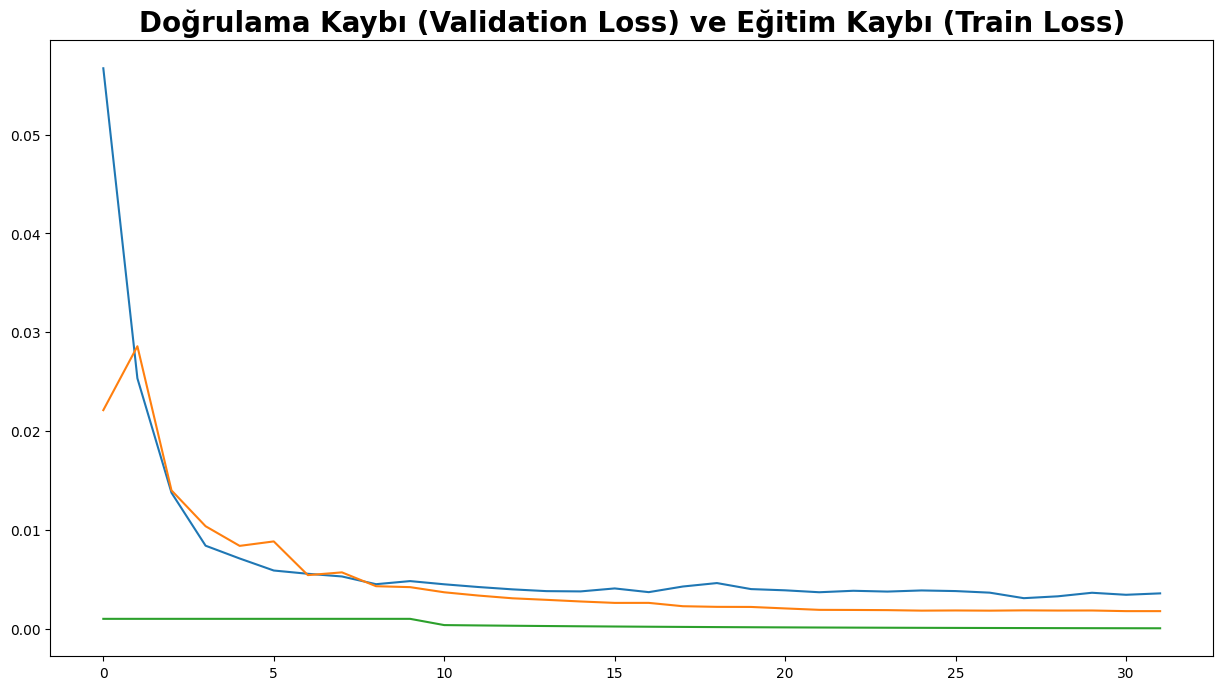

In [21]:
loss = pd.DataFrame(regressor.history.history)
fig=plt.figure(figsize=(15,8))
plt.title("Doğrulama Kaybı (Validation Loss) ve Eğitim Kaybı (Train Loss)", size=20, weight='bold')
plt.plot(loss)

In [22]:
predicted_prices = regressor.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

13/13 [==============================] - 0s 6ms/step


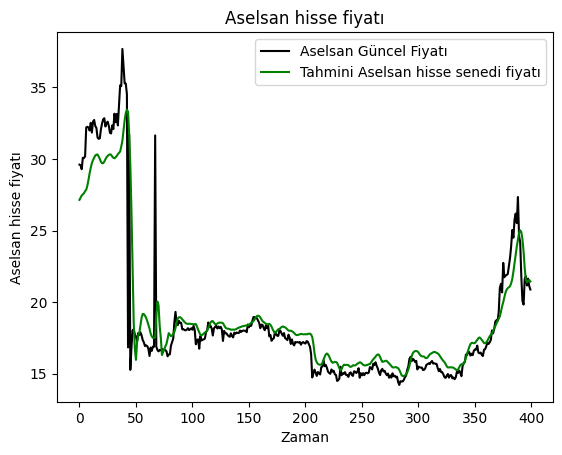

In [23]:
plt.plot(actual_prices, color='black', label="Aselsan Güncel Fiyatı")
plt.plot(predicted_prices, color= 'green', label="Tahmini Aselsan hisse senedi fiyatı")
plt.title("Aselsan hisse fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Aselsan hisse fiyatı")
plt.legend()
plt.show()


In [24]:
# Gelecek günü tahmin etmek
real_data = [model_inputs[len(model_inputs+1) - sequence_length:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [25]:
print(real_data.shape)
prediction = regressor.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

predictions = regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)
print(predictions)

(1, 50, 1)
1/1 [==============================] - 0s 19ms/step
[[21.251488]]
13/13 [==============================] - 0s 5ms/step
[[27.14029  ]
 [27.293997 ]
 [27.444937 ]
 [27.522608 ]
 [27.612774 ]
 [27.748331 ]
 [27.854866 ]
 [28.134647 ]
 [28.540281 ]
 [28.994177 ]
 [29.384153 ]
 [29.70447  ]
 [29.926472 ]
 [30.074835 ]
 [30.23985  ]
 [30.292204 ]
 [30.311087 ]
 [30.166979 ]
 [30.004131 ]
 [29.801237 ]
 [29.697992 ]
 [29.702034 ]
 [29.810606 ]
 [29.979088 ]
 [30.123615 ]
 [30.21217  ]
 [30.282835 ]
 [30.324078 ]
 [30.289263 ]
 [30.164299 ]
 [30.080505 ]
 [30.044249 ]
 [30.11444  ]
 [30.208164 ]
 [30.328228 ]
 [30.422607 ]
 [30.515257 ]
 [30.8625   ]
 [31.271767 ]
 [31.990534 ]
 [32.713734 ]
 [33.21299  ]
 [33.43964  ]
 [33.297485 ]
 [31.73799  ]
 [29.61817  ]
 [26.455875 ]
 [22.427643 ]
 [18.63472  ]
 [16.760513 ]
 [15.969819 ]
 [17.203304 ]
 [17.675861 ]
 [17.860119 ]
 [18.373331 ]
 [18.922672 ]
 [19.174276 ]
 [19.165348 ]
 [19.055248 ]
 [18.900658 ]
 [18.67718  ]
 [18.420544 ]
 [

In [26]:
print("Tahminlerin doğruluk skoru: {0}".format(r2_score(actual_prices, predicted_prices)))

Tahminlerin doğruluk skoru: 0.8708786817181275


C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_4808\3366296035.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



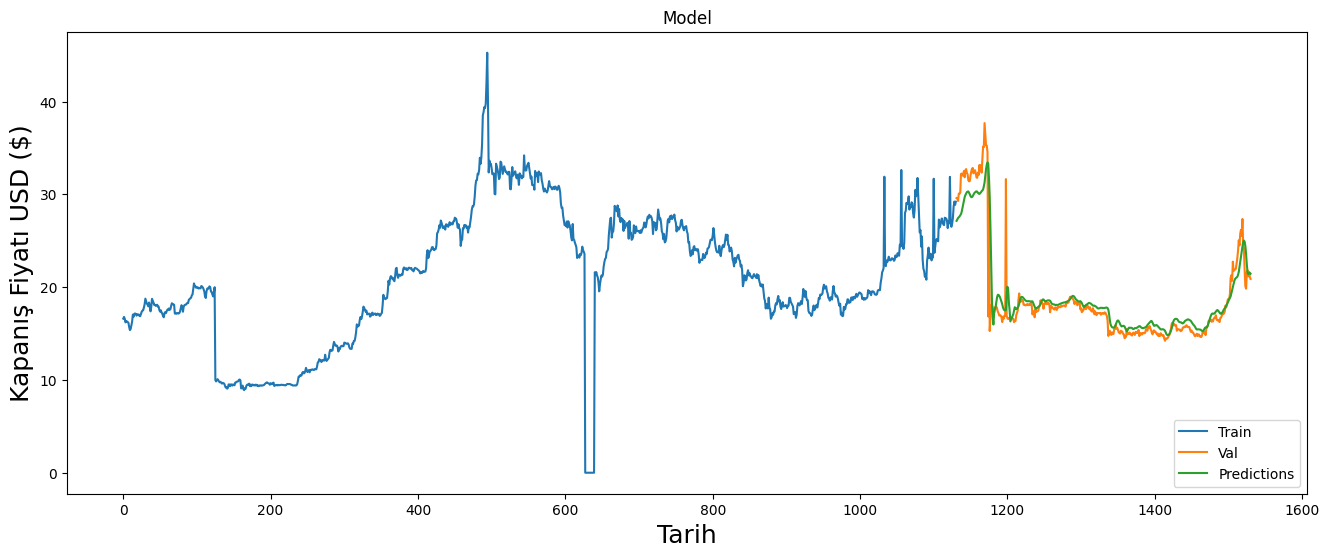

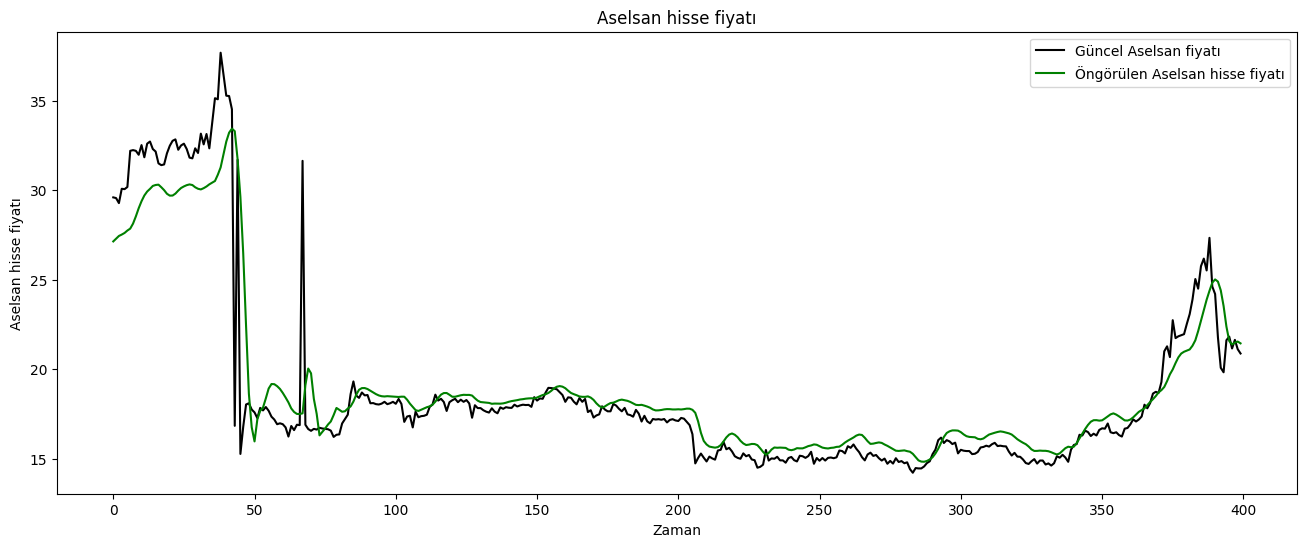

In [27]:
train = df[:1131]
valid = df[1131:]
valid['Predictions'] = predicted_prices

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatı USD ($)', fontsize=18)
plt.plot(train["CLOSING SESSION PRICE"])
plt.plot(valid[["CLOSING SESSION PRICE", 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(actual_prices, color='black', label="Güncel Aselsan fiyatı")
plt.plot(predicted_prices, color= 'green', label="Öngörülen Aselsan hisse fiyatı")
plt.title("Aselsan hisse fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Aselsan hisse fiyatı")
plt.legend()
plt.show()

In [28]:
regressor = Sequential()

regressor.add(SimpleRNN(units =50,activation=tf.keras.layers.LeakyReLU(), return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))


regressor.add(SimpleRNN(units = 50,activation=tf.keras.layers.LeakyReLU(), return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(tf.keras.layers.BatchNormalization())

regressor.add(SimpleRNN(units = 50,activation=tf.keras.layers.LeakyReLU(), return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(tf.keras.layers.BatchNormalization())


regressor.add(SimpleRNN(units = 50,activation=tf.keras.layers.LeakyReLU(), return_sequences = False))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 128, activation = tf.keras.layers.LeakyReLU()))

regressor.add(Dense(units = 1, activation = 'sigmoid'))


regressor.compile(optimizer='rmsprop',
              loss='mean_squared_error')

start_lr = 0.0001
rampup_epochs = 10
exp_decay = 0.1

def schedule(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)

lrate = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=True)
callbacks_list = [lrate]


regressor.fit(X_train, y_train,validation_data=(x_test,y_test), epochs = 32,callbacks=callbacks_list, batch_size = 32)



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/32
34/34 [==============================] - 3s 29ms/step - loss: 0.0511 - val_loss: 0.0227 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/32
34/34 [==============================] - 1s 21ms/step - loss: 0.0302 - val_loss: 0.0205 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/32
34/34 [==============================] - 1s 20ms/step - loss: 0.0193 - val_loss: 0.0175 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/32
34/34 [==============================] - 1s 21ms/step - loss: 0.0158 - val_loss: 0.0140 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/32
34/34 [==============================] - 1s 21ms/step - loss: 0.0130 - val_loss: 0.0121 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/32
34/34 [============

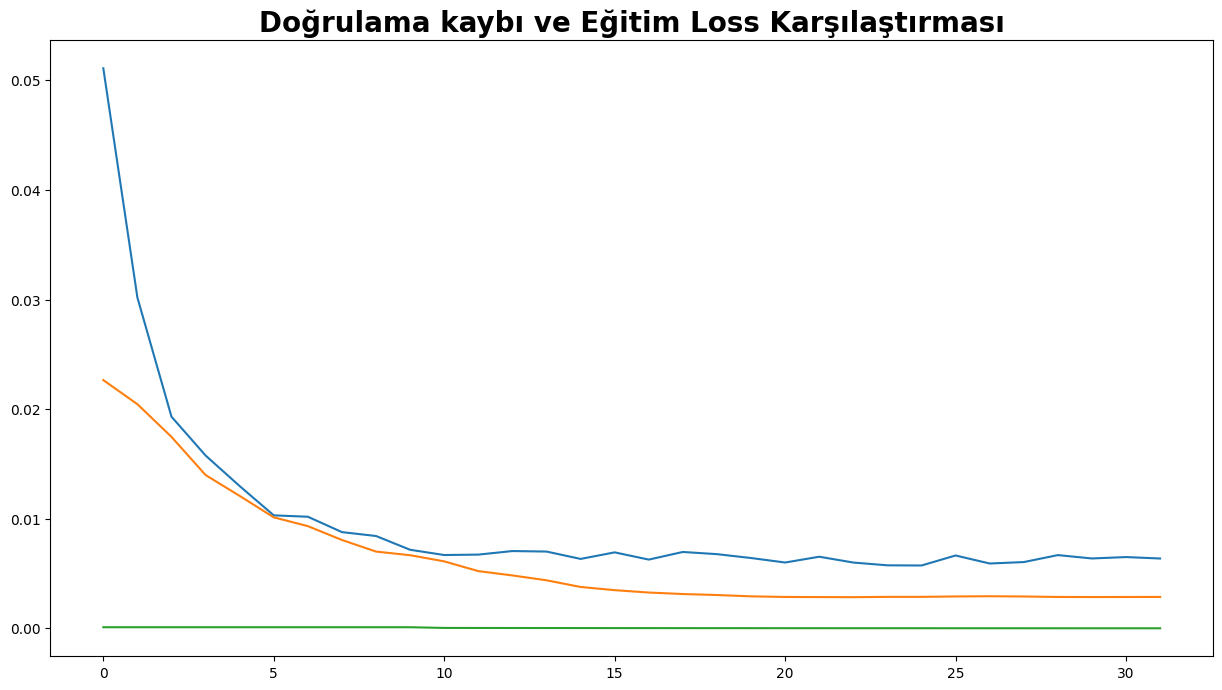

In [29]:
loss = pd.DataFrame(regressor.history.history)
fig=plt.figure(figsize=(15,8))
plt.title("Doğrulama kaybı ve Eğitim Loss Karşılaştırması", size=20, weight='bold')
plt.plot(loss)

In [30]:
predicted_prices = regressor.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

13/13 [==============================] - 0s 6ms/step


In [31]:
# gelecek gün tahmini
real_data = [model_inputs[len(model_inputs+1) - sequence_length:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [32]:
print(real_data.shape)
prediction = regressor.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

predictions = regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)
print(predictions)

(1, 50, 1)
1/1 [==============================] - 0s 25ms/step
[[22.265888]]
13/13 [==============================] - 0s 6ms/step
[[26.645563 ]
 [26.700985 ]
 [26.964727 ]
 [27.208515 ]
 [27.331964 ]
 [27.558802 ]
 [27.711367 ]
 [27.841675 ]
 [28.048788 ]
 [28.311064 ]
 [28.536398 ]
 [28.740137 ]
 [29.274145 ]
 [29.480938 ]
 [29.792467 ]
 [29.896917 ]
 [30.20453  ]
 [30.305597 ]
 [30.417774 ]
 [30.446228 ]
 [30.439743 ]
 [30.331682 ]
 [30.26615  ]
 [30.270231 ]
 [30.270903 ]
 [30.377857 ]
 [30.503134 ]
 [30.559845 ]
 [30.606146 ]
 [30.573904 ]
 [30.592808 ]
 [30.610924 ]
 [30.576868 ]
 [30.518297 ]
 [30.51224  ]
 [30.665098 ]
 [30.62154  ]
 [30.836916 ]
 [30.806547 ]
 [31.017973 ]
 [31.195866 ]
 [31.566494 ]
 [32.03424  ]
 [32.338573 ]
 [32.422794 ]
 [31.919245 ]
 [29.85673  ]
 [28.845922 ]
 [27.77186  ]
 [26.424076 ]
 [25.154642 ]
 [24.327486 ]
 [24.576096 ]
 [23.102898 ]
 [22.278242 ]
 [21.648113 ]
 [20.19866  ]
 [19.283024 ]
 [18.175695 ]
 [17.499022 ]
 [16.726097 ]
 [16.46974  ]
 [

In [33]:
from sklearn.metrics import r2_score
 
print("Tahminlerin Doğruluk Puanı: {0}".format(r2_score(actual_prices, predicted_prices)))



Tahminlerin Doğruluk Puanı: 0.7922250444587693


C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_4808\2972257673.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



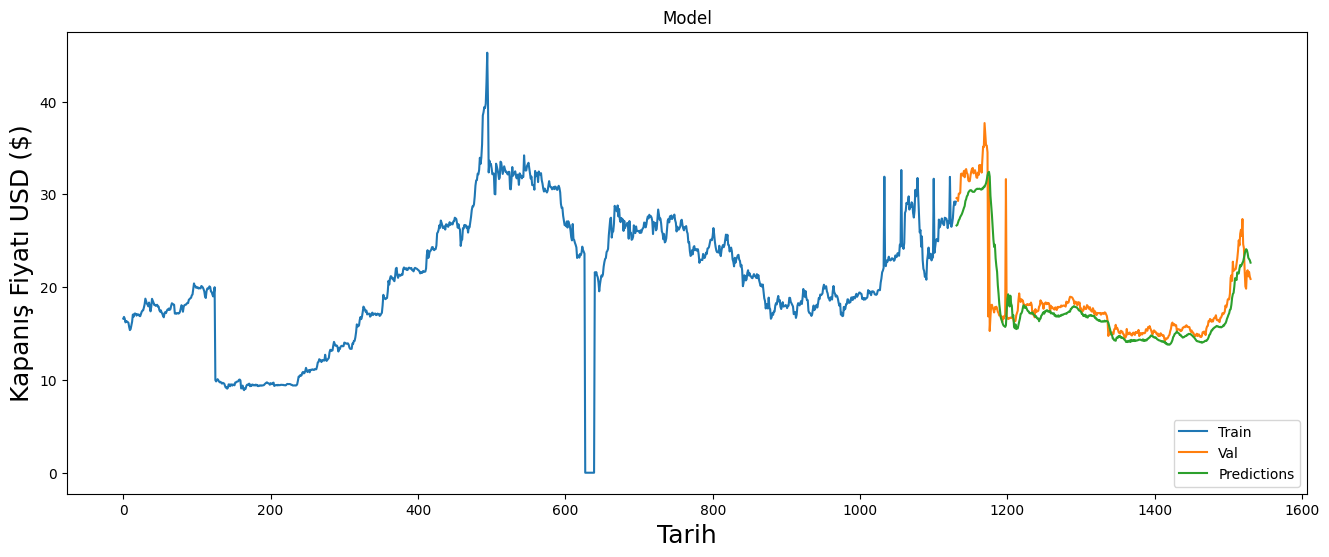

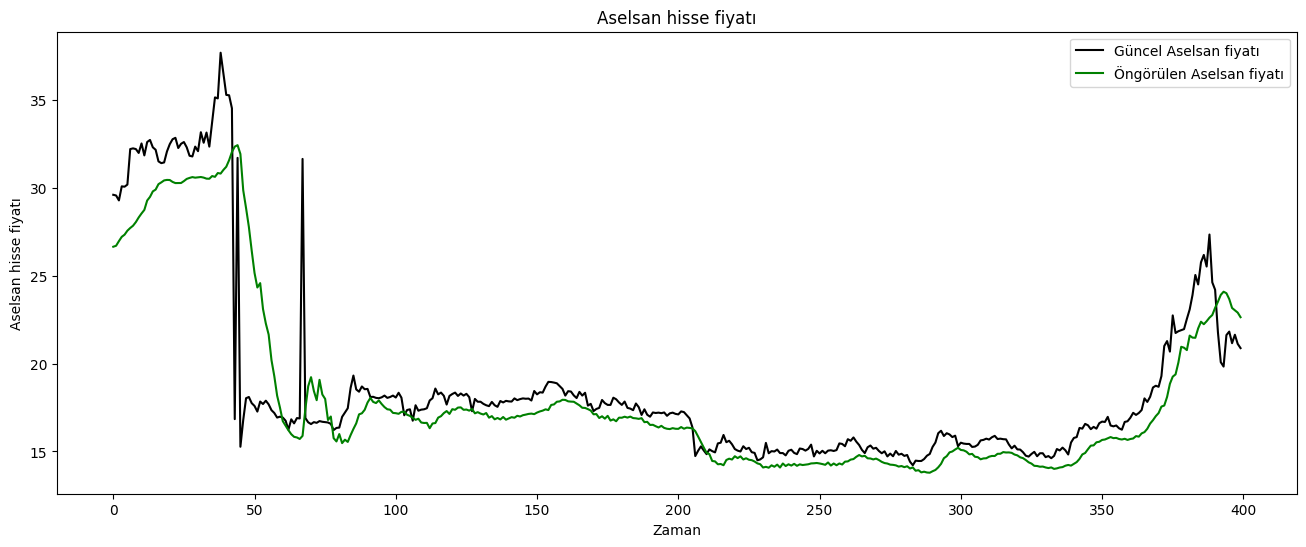

In [34]:
train = df[:1131]
valid = df[1131:]
valid['Predictions'] = predicted_prices

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatı USD ($)', fontsize=18)
plt.plot(train["CLOSING SESSION PRICE"])
plt.plot(valid[["CLOSING SESSION PRICE", 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(actual_prices, color='black', label="Güncel Aselsan fiyatı")
plt.plot(predicted_prices, color= 'green', label="Öngörülen Aselsan fiyatı")
plt.title("Aselsan hisse fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Aselsan hisse fiyatı")
plt.legend()
plt.show()

Bir değer dizisinin son değerini tahmin etmek için **LSTM yinelenen sinir ağını** kullanacağız.

LSTM modelini oluşturmadan önce aşağıdaki veri ön işleme ve özellik mühendisliğinin yapılması gerekir.

* **Veri kümesini oluşturun, tüm verilerin değişken olduğundan emin olun.
* Özellikleri normalleştirin.
* Eğitim ve test setlerine bölün.
* Bir değer dizisini veri kümesi matrisine dönüştürün.
* X=t ve Y=t+1 şeklinde yeniden şekillendirin.
* Girişi 3 boyutlu olacak şekilde yeniden şekillendirin (num_samples, num_timesteps, num_features).**

In [35]:
# LSTM modelini oluşturun
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(LSTM(units=50, activation='tanh'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(units=64, activation='tanh'))
model.add(Dropout(0.4))

# Çıkış katmanı
model.add(Dense(units=1, activation='sigmoid'))

# Öğrenme oranı programını ayarlayın
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

# Öğrenme oranı çizelgesiyle Adam optimizasyon aracını oluşturun
optimizer = Adam(learning_rate=lr_schedule)

# modeli optimize ediciyle örnekleyin
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Modeli eğitin
model.fit(X_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=32)


Epoch 1/25
34/34 [==============================] - 5s 55ms/step - loss: 0.0395 - val_loss: 0.0137
Epoch 2/25
34/34 [==============================] - 1s 35ms/step - loss: 0.0268 - val_loss: 0.0135
Epoch 3/25
34/34 [==============================] - 1s 36ms/step - loss: 0.0212 - val_loss: 0.0140
Epoch 4/25
34/34 [==============================] - 1s 35ms/step - loss: 0.0189 - val_loss: 0.0135
Epoch 5/25
34/34 [==============================] - 1s 36ms/step - loss: 0.0144 - val_loss: 0.0127
Epoch 6/25
34/34 [==============================] - 1s 35ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 7/25
34/34 [==============================] - 1s 35ms/step - loss: 0.0111 - val_loss: 0.0123
Epoch 8/25
34/34 [==============================] - 1s 35ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 9/25
34/34 [==============================] - 1s 35ms/step - loss: 0.0091 - val_loss: 0.0109
Epoch 10/25
34/34 [==============================] - 1s 35ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 11/

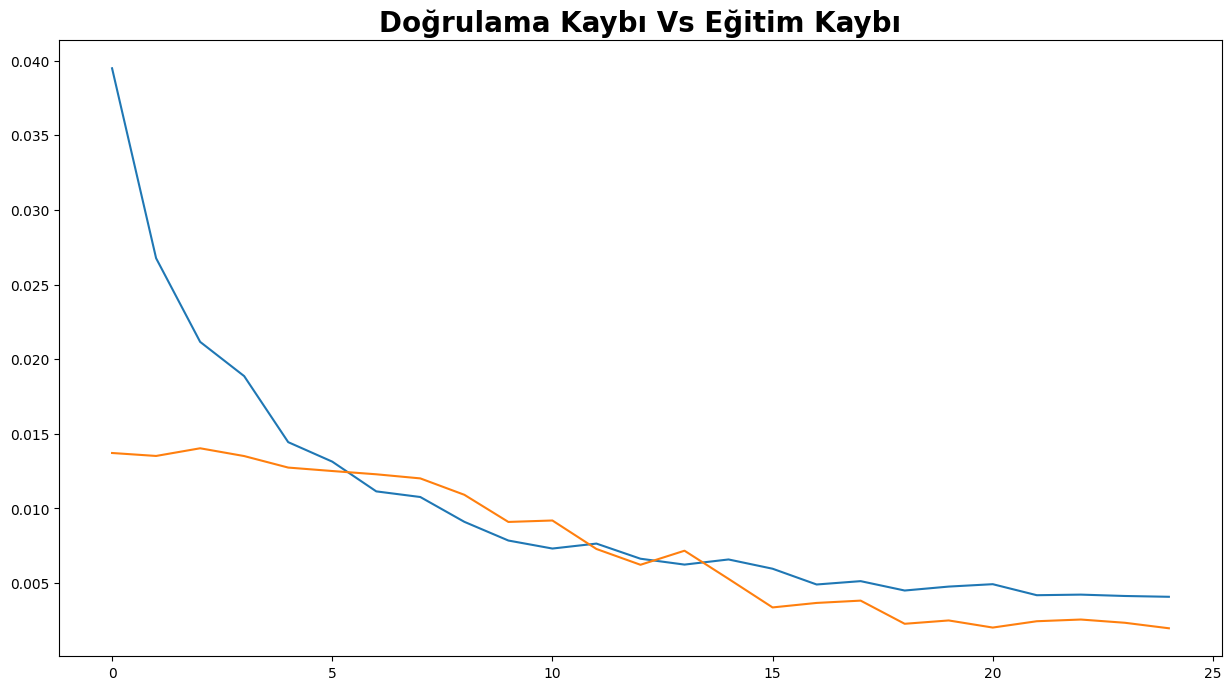

In [36]:
loss = pd.DataFrame(model.history.history)
fig=plt.figure(figsize=(15,8))
plt.title("Doğrulama Kaybı Vs Eğitim Kaybı", size=20, weight='bold')
plt.plot(loss)

In [37]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

13/13 [==============================] - 1s 11ms/step


In [38]:
# gelecek gün tahmini
real_data = [model_inputs[len(model_inputs+1) - sequence_length:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [39]:
print(real_data.shape)
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

predictions = regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)
print(predictions)

(1, 50, 1)
1/1 [==============================] - 0s 28ms/step
[[18.447145]]


13/13 [==============================] - 0s 6ms/step
[[26.645563 ]
 [26.700985 ]
 [26.964727 ]
 [27.208515 ]
 [27.331964 ]
 [27.558802 ]
 [27.711367 ]
 [27.841675 ]
 [28.048788 ]
 [28.311064 ]
 [28.536398 ]
 [28.740137 ]
 [29.274145 ]
 [29.480938 ]
 [29.792467 ]
 [29.896917 ]
 [30.20453  ]
 [30.305597 ]
 [30.417774 ]
 [30.446228 ]
 [30.439743 ]
 [30.331682 ]
 [30.26615  ]
 [30.270231 ]
 [30.270903 ]
 [30.377857 ]
 [30.503134 ]
 [30.559845 ]
 [30.606146 ]
 [30.573904 ]
 [30.592808 ]
 [30.610924 ]
 [30.576868 ]
 [30.518297 ]
 [30.51224  ]
 [30.665098 ]
 [30.62154  ]
 [30.836916 ]
 [30.806547 ]
 [31.017973 ]
 [31.195866 ]
 [31.566494 ]
 [32.03424  ]
 [32.338573 ]
 [32.422794 ]
 [31.919245 ]
 [29.85673  ]
 [28.845922 ]
 [27.77186  ]
 [26.424076 ]
 [25.154642 ]
 [24.327486 ]
 [24.576096 ]
 [23.102898 ]
 [22.278242 ]
 [21.648113 ]
 [20.19866  ]
 [19.283024 ]
 [18.175695 ]
 [17.499022 ]
 [16.726097 ]
 [16.46974  ]
 [16.20939  ]
 [15.983194 ]
 [15.834099 ]
 [15.79776  ]
 [15.7127   ]
 [15.8888

In [40]:
print("Tahminlerin doğruluk puanı: {0}".format(r2_score(actual_prices, predicted_prices)))

Tahminlerin doğruluk puanı: 0.8569363759807528


C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_4808\271338869.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



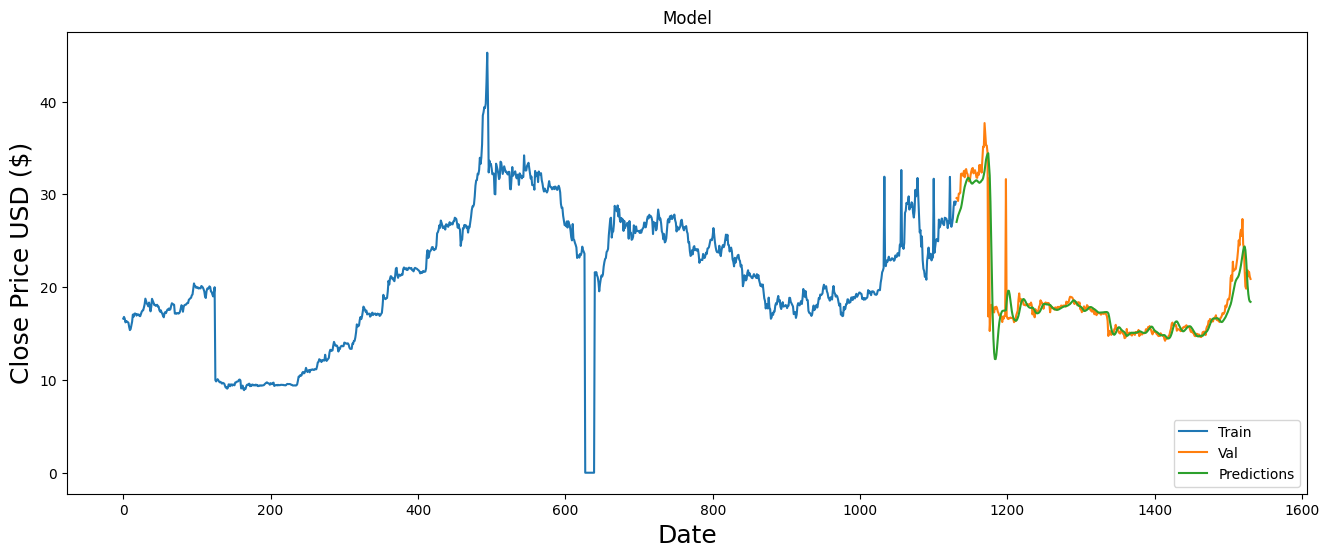

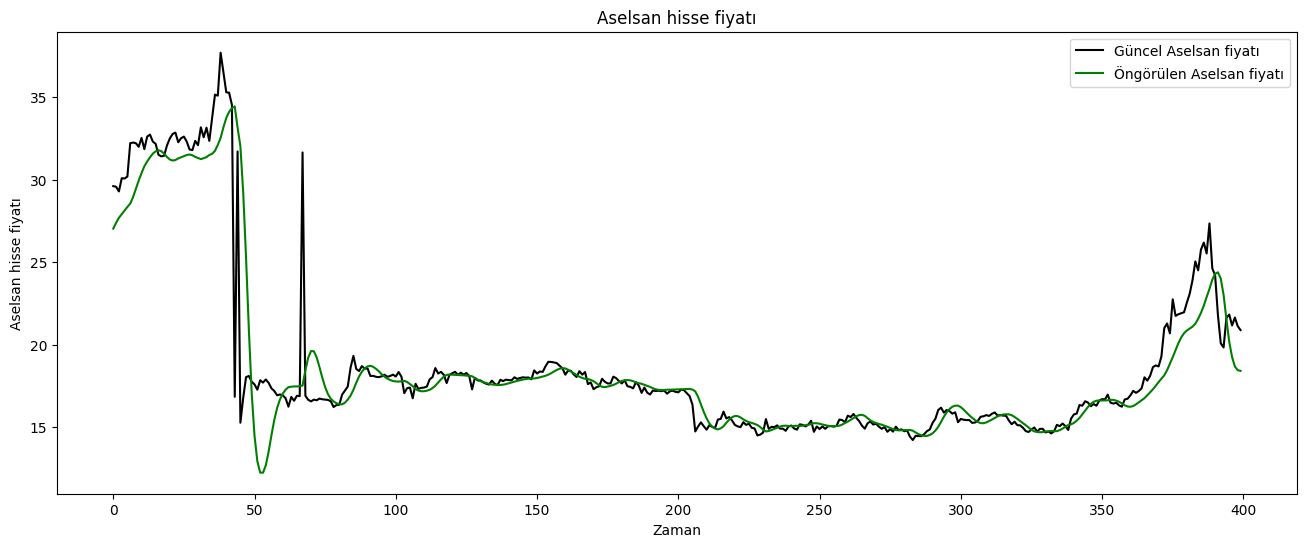

In [41]:
train = df[:1131]
valid = df[1131:]
valid['Predictions'] = predicted_prices



plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train["CLOSING SESSION PRICE"])
plt.plot(valid[["CLOSING SESSION PRICE", 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()



plt.figure(figsize=(16,6))
plt.plot(actual_prices, color='black', label="Güncel Aselsan fiyatı")
plt.plot(predicted_prices, color= 'green', label="Öngörülen Aselsan fiyatı")
plt.title("Aselsan hisse fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Aselsan hisse fiyatı")
plt.legend()
plt.show()

In [42]:
model2 = Sequential()

model2.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model2.add(Dropout(0.2))

model2.add(tf.keras.layers.BatchNormalization())

model2.add(GRU(units=50, return_sequences=True, activation='tanh'))
model2.add(Dropout(0.2))

model2.add(tf.keras.layers.BatchNormalization())

model2.add(GRU(units=50, activation='tanh'))
model2.add(Dropout(0.2))

model2.add(tf.keras.layers.BatchNormalization())
model2.add(Dense(units=64, activation='tanh'))
model2.add(Dropout(0.4))


model2.add(Dense(units=1, activation='tanh'))

In [43]:
model2.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True), loss='mean_squared_error')

model2.fit(X_train, y_train,validation_data=(x_test,y_test), epochs=28, batch_size=64)

Epoch 1/28
17/17 [==============================] - 5s 78ms/step - loss: 0.3552 - val_loss: 0.1519
Epoch 2/28
17/17 [==============================] - 1s 40ms/step - loss: 0.1286 - val_loss: 0.1751
Epoch 3/28
17/17 [==============================] - 1s 40ms/step - loss: 0.0763 - val_loss: 0.0890
Epoch 4/28
17/17 [==============================] - 1s 39ms/step - loss: 0.0430 - val_loss: 0.0326
Epoch 5/28
17/17 [==============================] - 1s 39ms/step - loss: 0.0217 - val_loss: 0.0204
Epoch 6/28
17/17 [==============================] - 1s 41ms/step - loss: 0.0130 - val_loss: 0.0184
Epoch 7/28
17/17 [==============================] - 1s 40ms/step - loss: 0.0081 - val_loss: 0.0164
Epoch 8/28
17/17 [==============================] - 1s 40ms/step - loss: 0.0062 - val_loss: 0.0149
Epoch 9/28
17/17 [==============================] - 1s 40ms/step - loss: 0.0058 - val_loss: 0.0134
Epoch 10/28
17/17 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0121
Epoch 11/

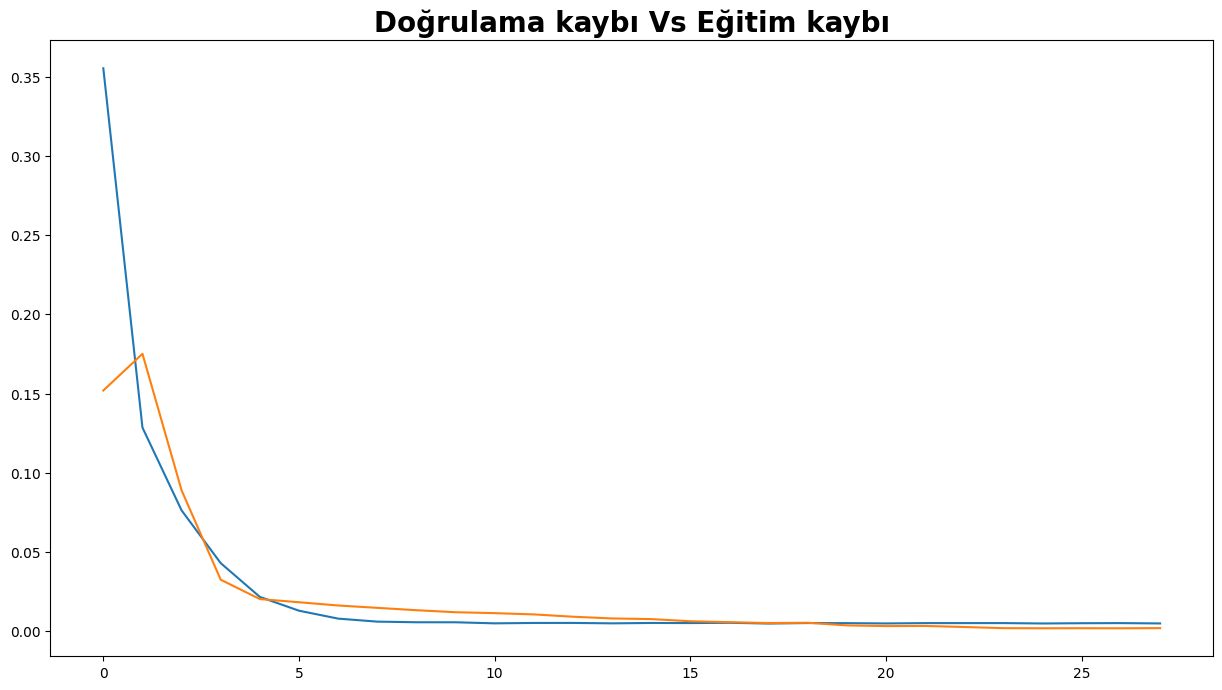

In [44]:
loss = pd.DataFrame(model2.history.history)
fig=plt.figure(figsize=(15,8))
plt.title("Doğrulama kaybı Vs Eğitim kaybı", size=20, weight='bold')
plt.plot(loss)

In [45]:
sequence_length = 50
actual_prices = dataset_test["CLOSING SESSION PRICE"].values

total_dataset = pd.concat((dataset_train["CLOSING SESSION PRICE"], dataset_test["CLOSING SESSION PRICE"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(dataset_test) - sequence_length:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []
for x in range(sequence_length, len(model_inputs)):
    x_test.append(model_inputs[x-sequence_length:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model2.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# gelecek günü tahminleme
real_data = [model_inputs[len(model_inputs+1) - sequence_length:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

 
print("Tahminlerin doğruluk puanı: {0}".format(r2_score(actual_prices, predicted_prices)))



13/13 [==============================] - 1s 8ms/step
Tahminlerin doğruluk puanı: 0.8502864410368058


C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_4808\2972257673.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



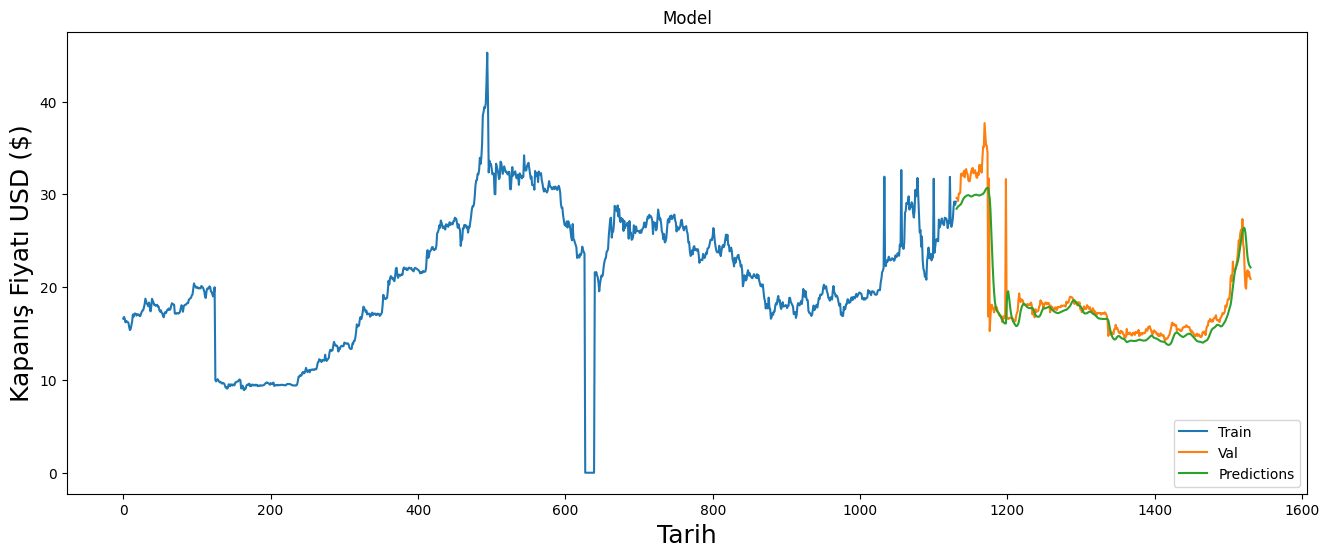

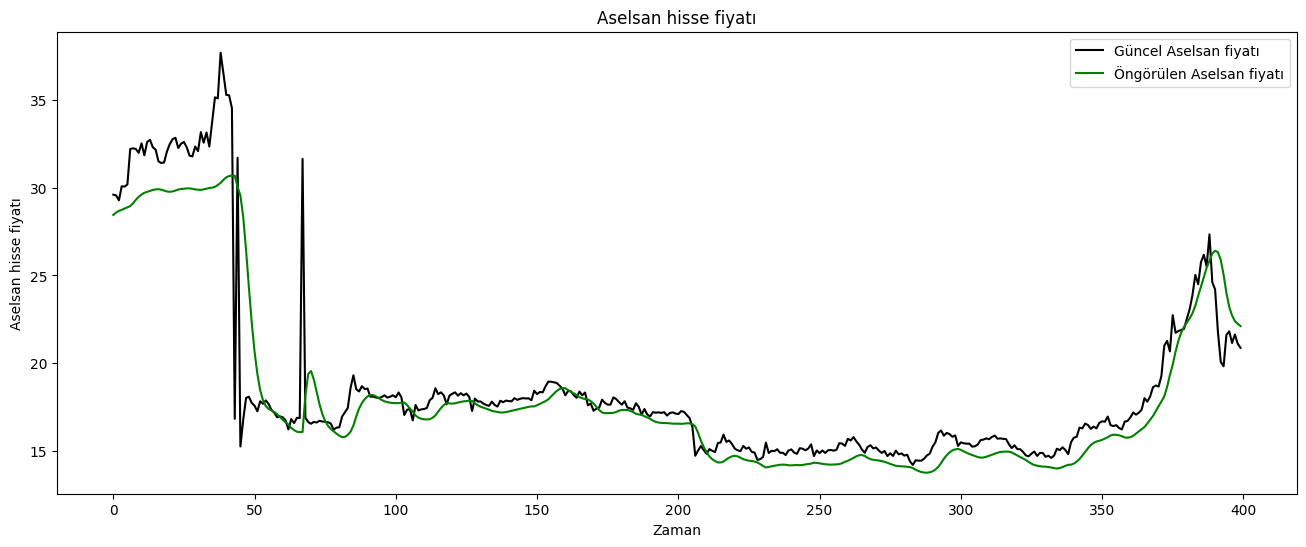

In [46]:
train = df[:1131]
valid = df[1131:]
valid['Predictions'] = predicted_prices

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatı USD ($)', fontsize=18)
plt.plot(train["CLOSING SESSION PRICE"])
plt.plot(valid[["CLOSING SESSION PRICE", 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(actual_prices, color='black', label="Güncel Aselsan fiyatı")
plt.plot(predicted_prices, color= 'green', label="Öngörülen Aselsan fiyatı")
plt.title("Aselsan hisse fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Aselsan hisse fiyatı")
plt.legend()
plt.show()

In [47]:
FEATURES = ['OPENING PRICE','HIGHEST PRICE','CLOSING SESSION PRICE']

print('FEATURE LIST')
print([f for f in FEATURES])


# Özellikleri içeren veri kümesini oluşturun ve verileri ÖZELLİKLER listesine göre filtreleyin
data = pd.DataFrame(df)
data_filtered = data[FEATURES]


# Verileri ölçeklendirmeye hazırlamak için bir tahmin sütunu ekliyoruz ve yapay değerler ayarlıyoruz
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['CLOSING SESSION PRICE']


data_filtered_ext.tail()
nrows = data_filtered.shape[0]


# Verileri numpy değerlere dönüştürün
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)


# Her özelliği 0 ile 1 arasında bir aralığa ölçeklendirerek verileri dönüştürün
sc = MinMaxScaler()
np_data_scaled = sc.fit_transform(np_data_unscaled)


# Tahminleri ölçeklendirmek için tek bir sütun üzerinde çalışan ayrı bir ölçekleyici oluşturma
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['CLOSING SESSION PRICE'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
sequence_length = 50


# Tahmin Endeksi
index_Close = data.columns.get_loc('CLOSING SESSION PRICE')


# Eğitim verilerini eğitim ve eğitim veri kümelerine bölün
# İlk adım olarak, modeli verinin %80'i üzerinde eğitecek satır sayısını alıyoruz
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)


# Eğitim ve test verilerini oluşturun
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]
print(train_data.shape)
print(test_data.shape)



# RNN'nin [örnekler, zaman adımları, özellikler] biçimindeki verilere ihtiyacı var

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    print(data_len)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, 2]) 
    
    # X ve y'yi numpy dizilerine dönüştürün.
    x = np.array(x)
    y = np.array(y)
    return x, y


# Finansal açıdan uygun veri seti oluştur ve test verilerini oluştur.
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Şekilleri yazdır: sonuç şu şekildedir: (satırlar, eğitim_sırası, özellikler) (tahmin değeri, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

FEATURE LIST
['OPENING PRICE', 'HIGHEST PRICE', 'CLOSING SESSION PRICE']
(1531, 3)
(1225, 3)
(356, 3)
1225
356
(1175, 50, 3) (1175,)
(306, 50, 3) (306,)


In [48]:
model = Sequential()


# n_neurons = input_shape ve x_train.shape[2] değişkenlere sahip her bir zaman damgasıyla olan model
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dropout(0.2))
model.add(LSTM(n_neurons, return_sequences=False))

model.add(Dense(16))

model.add(Dense(1,activation='tanh'))


# Modeli derleyin
model.compile(optimizer='adam', loss='mse')



# Modeli eğitelim
epochs = 16
batch_size = 64

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )


150 50 3
Epoch 1/16
19/19 [==============================] - 5s 148ms/step - loss: 0.0269 - val_loss: 0.0044
Epoch 2/16
19/19 [==============================] - 2s 130ms/step - loss: 0.0055 - val_loss: 6.0130e-04
Epoch 3/16
19/19 [==============================] - 3s 133ms/step - loss: 0.0043 - val_loss: 5.1879e-04
Epoch 4/16
19/19 [==============================] - 3s 134ms/step - loss: 0.0037 - val_loss: 3.9578e-04
Epoch 5/16
19/19 [==============================] - 3s 134ms/step - loss: 0.0036 - val_loss: 4.4953e-04
Epoch 6/16
19/19 [==============================] - 3s 136ms/step - loss: 0.0034 - val_loss: 3.8708e-04
Epoch 7/16
19/19 [==============================] - 3s 137ms/step - loss: 0.0034 - val_loss: 4.3399e-04
Epoch 8/16
19/19 [==============================] - 3s 136ms/step - loss: 0.0033 - val_loss: 3.4646e-04
Epoch 9/16
19/19 [==============================] - 3s 137ms/step - loss: 0.0029 - val_loss: 4.1636e-04
Epoch 10/16
19/19 [==============================] - 3s 136

In [49]:
# Tahmin edilen değerleri al
y_pred_scaled = model.predict(x_test)


# Tahmin edilen değerleri ölçek dışına çıkar
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))


# Ortalama Mutlak Hata
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Medyan Mutlak Hata (MAE): {np.round(MAE, 2)}')


# Ortalama Mutlak Yüzde Hata
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Ortalama Mutlak Yüzde Hatası (MAPE): {np.round(MAPE, 2)} %')


# Ortanca Mutlak Yüzde Hata Oranı
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Medyan Mutlak Yüzde Hatası (MDAPE): {np.round(MDAPE, 2)} %')

10/10 [==============================] - 1s 15ms/step
Medyan Mutlak Hata (MAE): 0.41
Ortalama Mutlak Yüzde Hatası (MAPE): 2.28 %
Medyan Mutlak Yüzde Hatası (MDAPE): 1.48 %


In [50]:
print("Tahminlerin doğruluk puanı: {0}".format(r2_score(y_test, y_pred_scaled)))

Tahminlerin doğruluk puanı: 0.9041597371757811


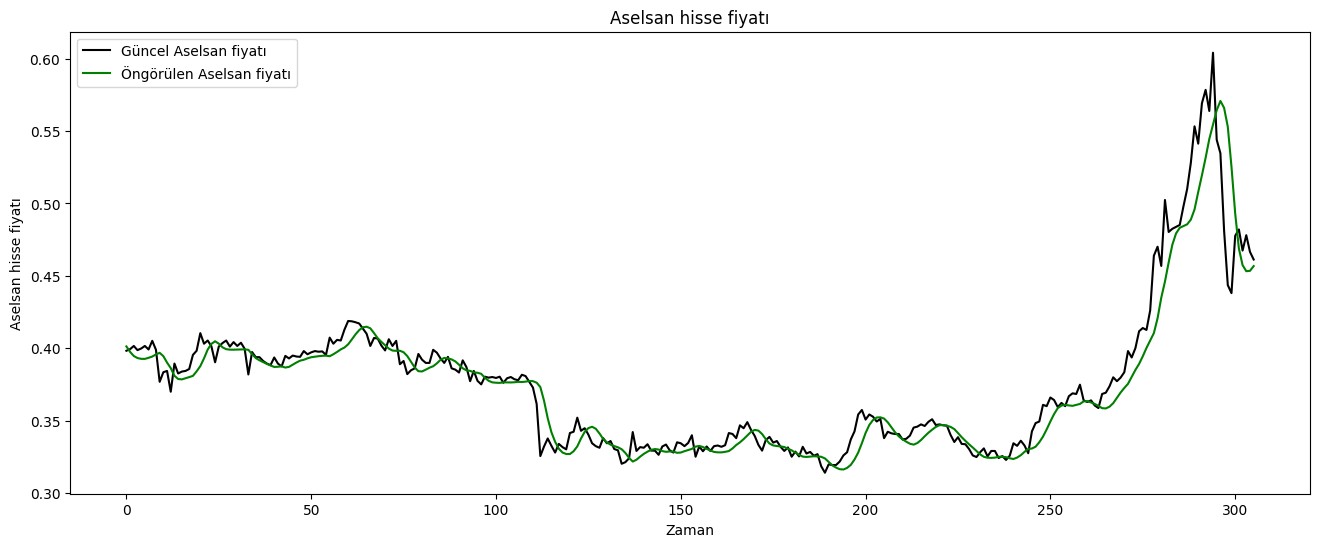

In [51]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='black', label="Güncel Aselsan fiyatı")
plt.plot(y_pred_scaled, color= 'green', label="Öngörülen Aselsan fiyatı")
plt.title("Aselsan hisse fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Aselsan hisse fiyatı")
plt.legend()
plt.show()

In [52]:
df = pd.read_csv("C:/Users/Serkan POLAT/Desktop/Borsa Istanbul Turkish Stock Exchange Dataset/Finansal Zaman Serisi Tahmin Projesi/stocks/BIOEN.csv")

In [53]:
df

,TRADE DATE,INSTRUMENT SERIES CODE,INSTRUMENT NAME,MARKET SEGMENT,MARKET,INSTRUMENT TYPE,INSTRUMENT CLASS,MARKET MAKER,BIST 100 INDEX,BIST 30 INDEX,...,SHORT SALE VWAP,TRADED VALUE OF SHORT SALE TRADES,TRADED VOLUME OF SHORT SALE TRADES,NUMBER OF CONTRACTS OF SHORT SALE TRADES,LOWEST TRADE REPORT PRICE,HIGHEST TRADE REPORT PRICE,TRADE REPORT VWAP,TRADE REPORT TRADED VALUE,TRADE REPORT TRADED VOLUME,NUMBER OF TRADE REPORTS
0,2021-04-28,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
1,2021-04-29,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
2,2021-04-30,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
3,2021-05-03,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
4,2021-05-04,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,0,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2021-12-27,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,1,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
164,2021-12-28,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,1,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
165,2021-12-29,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,1,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0
166,2021-12-30,BIOEN,BIOTREND CEVRE VE ENERJI,Z,MSPOT,MSPOTEQT,MSPOTEQTBIOEN,0,1,0,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0


In [54]:
data_temp = df.loc[:,:]
trace = go.Candlestick(x = df['TRADE DATE'],                       
                       open = df['OPENING PRICE'],                       
                       high = df['HIGHEST PRICE'],                       
                       low = df['LOWEST PRICE'],                       
                       close = df['CLOSING SESSION PRICE'],  
                      increasing = dict(fillcolor = 'greenyellow', 
                                         line = dict(color = 'green', 
                                                     width = 3
                                                    )),
                       decreasing = dict(fillcolor = 'lightcoral'),                       
                       whiskerwidth = 0.2)
data_figure_2 = [trace]
layout = dict(title = 'BIOEN Hisse Fiyat Verisi ')
fig = dict(data=data_figure_2, 
           layout=layout)
offline.iplot(fig)

In [55]:
prediction_days = 50

dataset_test = df.loc[0:400,:]
actual_prices = dataset_test["CLOSING SESSION PRICE"].values

total_dataset = pd.concat((dataset_train["CLOSING SESSION PRICE"], dataset_test["CLOSING SESSION PRICE"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(dataset_test) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [56]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = regressor.predict(x_test)

predicted_prices = scaler.inverse_transform(predicted_prices)

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 8ms/step


In [57]:
x_test.shape

(168, 50, 1)

In [58]:
real_data = [model_inputs[len(model_inputs+1) - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [59]:
print("Tahminlerin doğruluk puanı: {0}".format(r2_score(actual_prices, predicted_prices)))

Tahminlerin doğruluk puanı: 0.7875625445827248


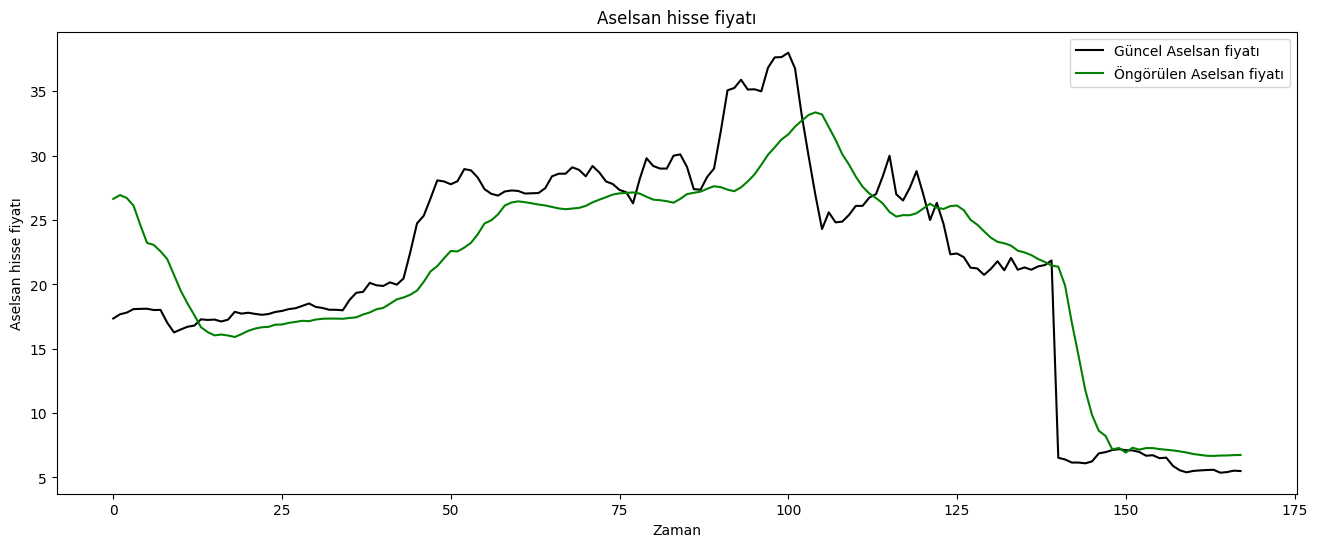

In [60]:
plt.figure(figsize=(16,6))
plt.plot(actual_prices, color='black', label="Güncel Aselsan fiyatı")
plt.plot(predicted_prices, color= 'green', label="Öngörülen Aselsan fiyatı")
plt.title("Aselsan hisse fiyatı")
plt.xlabel("Zaman")
plt.ylabel("Aselsan hisse fiyatı")
plt.legend()
plt.show()